### WIP Sentiment Analysis
#### Tutorial links
https://stackabuse.com/python-for-nlp-sentiment-analysis-with-scikit-learn/

https://www.youtube.com/watch?v=QpzMWQvxXWk


In [1]:
# imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
import re
from textblob import TextBlob
plt.style.use('ggplot')
nltk.download('all-corpora')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('maxent_ne_chunker')
nltk.download('vader_lexicon')
%matplotlib inline

[nltk_data] Downloading collection 'all-corpora'
[nltk_data]    | 
[nltk_data]    | Downloading package abc to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/abc.zip.
[nltk_data]    | Downloading package alpino to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/alpino.zip.
[nltk_data]    | Downloading package bcp47 to /root/nltk_data...
[nltk_data]    | Downloading package biocreative_ppi to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Unzipping corpora/biocreative_ppi.zip.
[nltk_data]    | Downloading package brown to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/brown.zip.
[nltk_data]    | Downloading package brown_tei to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/brown_tei.zip.
[nltk_data]    | Downloading package cess_cat to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/cess_cat.zip.
[nltk_data]    | Downloading package cess_esp to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/cess_esp.zip.
[nltk_data]    | D

In [3]:
from google.colab import drive
drive.mount('/gdrive')

Mounted at /gdrive


In [4]:
# read the data
# Initialize an empty DataFrame to store the data
reviews = pd.DataFrame()

# Define the file path
file_path = '/gdrive/My Drive/ADC/yelp_project/datasets/yelp_academic_dataset_review.json'

# Specify the chunk size
chunksize = 100000

# Read the file in chunks and concatenate them
for chunk in pd.read_json(file_path, lines=True, chunksize=chunksize):
    reviews = pd.concat([reviews, chunk])

# Now, 'all_data' contains the entire dataset

In [5]:
# show the data
reviews.head()


,review_id,user_id,business_id,stars,useful,funny,cool,text,date
0,KU_O5udG6zpxOg-VcAEodg,mh_-eMZ6K5RLWhZyISBhwA,XQfwVwDr-v0ZS3_CbbE5Xw,3,0,0,0,"If you decide to eat here, just be aware it is...",2018-07-07 22:09:11
1,BiTunyQ73aT9WBnpR9DZGw,OyoGAe7OKpv6SyGZT5g77Q,7ATYjTIgM3jUlt4UM3IypQ,5,1,0,1,I've taken a lot of spin classes over the year...,2012-01-03 15:28:18
2,saUsX_uimxRlCVr67Z4Jig,8g_iMtfSiwikVnbP2etR0A,YjUWPpI6HXG530lwP-fb2A,3,0,0,0,Family diner. Had the buffet. Eclectic assortm...,2014-02-05 20:30:30
3,AqPFMleE6RsU23_auESxiA,_7bHUi9Uuf5__HHc_Q8guQ,kxX2SOes4o-D3ZQBkiMRfA,5,1,0,1,"Wow! Yummy, different, delicious. Our favo...",2015-01-04 00:01:03
4,Sx8TMOWLNuJBWer-0pcmoA,bcjbaE6dDog4jkNY91ncLQ,e4Vwtrqf-wpJfwesgvdgxQ,4,1,0,1,Cute interior and owner (?) gave us tour of up...,2017-01-14 20:54:15


In [6]:
# read business data
business = pd.read_json('/gdrive/My Drive/ADC/yelp_project/datasets/yelp_academic_dataset_business.json', lines=True)

In [7]:
# show business data
business.head(10)

,business_id,name,address,city,state,postal_code,latitude,longitude,stars,review_count,is_open,attributes,categories,hours
0,Pns2l4eNsfO8kk83dixA6A,"Abby Rappoport, LAC, CMQ","1616 Chapala St, Ste 2",Santa Barbara,CA,93101,34.426679,-119.711197,5.0,7,0,{'ByAppointmentOnly': 'True'},"Doctors, Traditional Chinese Medicine, Naturop...",None
1,mpf3x-BjTdTEA3yCZrAYPw,The UPS Store,87 Grasso Plaza Shopping Center,Affton,MO,63123,38.551126,-90.335695,3.0,15,1,{'BusinessAcceptsCreditCards': 'True'},"Shipping Centers, Local Services, Notaries, Ma...","{'Monday': '0:0-0:0', 'Tuesday': '8:0-18:30', ..."
2,tUFrWirKiKi_TAnsVWINQQ,Target,5255 E Broadway Blvd,Tucson,AZ,85711,32.223236,-110.880452,3.5,22,0,"{'BikeParking': 'True', 'BusinessAcceptsCredit...","Department Stores, Shopping, Fashion, Home & G...","{'Monday': '8:0-22:0', 'Tuesday': '8:0-22:0', ..."
3,MTSW4McQd7CbVtyjqoe9mw,St Honore Pastries,935 Race St,Philadelphia,PA,19107,39.955505,-75.155564,4.0,80,1,"{'RestaurantsDelivery': 'False', 'OutdoorSeati...","Restaurants, Food, Bubble Tea, Coffee & Tea, B...","{'Monday': '7:0-20:0', 'Tuesday': '7:0-20:0', ..."
4,mWMc6_wTdE0EUBKIGXDVfA,Perkiomen Valley Brewery,101 Walnut St,Green Lane,PA,18054,40.338183,-75.471659,4.5,13,1,"{'BusinessAcceptsCreditCards': 'True', 'Wheelc...","Brewpubs, Breweries, Food","{'Wednesday': '14:0-22:0', 'Thursday': '16:0-2..."
5,CF33F8-E6oudUQ46HnavjQ,Sonic Drive-In,615 S Main St,Ashland City,TN,37015,36.269593,-87.058943,2.0,6,1,"{'BusinessParking': 'None', 'BusinessAcceptsCr...","Burgers, Fast Food, Sandwiches, Food, Ice Crea...","{'Monday': '0:0-0:0', 'Tuesday': '6:0-22:0', '..."
6,n_0UpQx1hsNbnPUSlodU8w,Famous Footwear,"8522 Eager Road, Dierbergs Brentwood Point",Brentwood,MO,63144,38.627695,-90.340465,2.5,13,1,"{'BusinessAcceptsCreditCards': 'True', 'Restau...","Sporting Goods, Fashion, Shoe Stores, Shopping...","{'Monday': '0:0-0:0', 'Tuesday': '10:0-18:0', ..."
7,qkRM_2X51Yqxk3btlwAQIg,Temple Beth-El,400 Pasadena Ave S,St. Petersburg,FL,33707,27.766590,-82.732983,3.5,5,1,None,"Synagogues, Religious Organizations","{'Monday': '9:0-17:0', 'Tuesday': '9:0-17:0', ..."
8,k0hlBqXX-Bt0vf1op7Jr1w,Tsevi's Pub And Grill,8025 Mackenzie Rd,Affton,MO,63123,38.565165,-90.321087,3.0,19,0,"{'Caters': 'True', 'Alcohol': 'u'full_bar'', '...","Pubs, Restaurants, Italian, Bars, American (Tr...",None
9,bBDDEgkFA1Otx9Lfe7BZUQ,Sonic Drive-In,2312 Dickerson Pike,Nashville,TN,37207,36.208102,-86.768170,1.5,10,1,"{'RestaurantsAttire': ''casual'', 'Restaurants...","Ice Cream & Frozen Yogurt, Fast Food, Burgers,...","{'Monday': '0:0-0:0', 'Tuesday': '6:0-21:0', '..."


In [8]:
# join the files using business id
reviws_business = pd.merge(business, reviews, on='business_id')

In [9]:
# show the new data
reviws_business.head(10)

,business_id,name,address,city,state,postal_code,latitude,longitude,stars_x,review_count,...,categories,hours,review_id,user_id,stars_y,useful,funny,cool,text,date
0,Pns2l4eNsfO8kk83dixA6A,"Abby Rappoport, LAC, CMQ","1616 Chapala St, Ste 2",Santa Barbara,CA,93101,34.426679,-119.711197,5.0,7,...,"Doctors, Traditional Chinese Medicine, Naturop...",None,9vwYDBVI3ymdqcyJ5WW2Tg,e0imecnX_9MtLnS2rUZM-A,5,3,2,1,I've had acupuncture treatments with Abby over...,2012-05-02 18:07:38
1,Pns2l4eNsfO8kk83dixA6A,"Abby Rappoport, LAC, CMQ","1616 Chapala St, Ste 2",Santa Barbara,CA,93101,34.426679,-119.711197,5.0,7,...,"Doctors, Traditional Chinese Medicine, Naturop...",None,OXgg1LdxHDv3CBU5-xi2lA,_Q0fdLVoTnlNkEypUvNkHA,5,1,0,0,Abby is an amazing practitioner. In a treatmen...,2013-03-01 06:11:05
2,Pns2l4eNsfO8kk83dixA6A,"Abby Rappoport, LAC, CMQ","1616 Chapala St, Ste 2",Santa Barbara,CA,93101,34.426679,-119.711197,5.0,7,...,"Doctors, Traditional Chinese Medicine, Naturop...",None,DG64cjud9cWB4fANskVxSw,ycUooVIDWPgXPf6niW-FWQ,4,2,0,0,I went to see Abby for some digestive issues. ...,2013-01-17 00:05:43
3,Pns2l4eNsfO8kk83dixA6A,"Abby Rappoport, LAC, CMQ","1616 Chapala St, Ste 2",Santa Barbara,CA,93101,34.426679,-119.711197,5.0,7,...,"Doctors, Traditional Chinese Medicine, Naturop...",None,hzvRRb40oPttxAdyr7kfow,CiwVvb7jWijWB5jkmatzKA,5,0,1,0,"Abby helped me with some longstanding issues, ...",2015-03-16 03:43:08
4,Pns2l4eNsfO8kk83dixA6A,"Abby Rappoport, LAC, CMQ","1616 Chapala St, Ste 2",Santa Barbara,CA,93101,34.426679,-119.711197,5.0,7,...,"Doctors, Traditional Chinese Medicine, Naturop...",None,xUkBPk-QfcW4i3MRU5TeXw,QkCbMKBktkrkOFJugHvY6w,5,0,0,0,"Recently, I referred a patient of mine with mu...",2013-03-05 18:45:07
5,Pns2l4eNsfO8kk83dixA6A,"Abby Rappoport, LAC, CMQ","1616 Chapala St, Ste 2",Santa Barbara,CA,93101,34.426679,-119.711197,5.0,7,...,"Doctors, Traditional Chinese Medicine, Naturop...",None,7zGoOrFQT5WylJYax1pYnA,ZCACyKwpELPtwV4Hue5pcg,5,1,0,0,Abby Rappoport helped me achieve a long lost s...,2012-08-09 20:43:27
6,Pns2l4eNsfO8kk83dixA6A,"Abby Rappoport, LAC, CMQ","1616 Chapala St, Ste 2",Santa Barbara,CA,93101,34.426679,-119.711197,5.0,7,...,"Doctors, Traditional Chinese Medicine, Naturop...",None,2DhY5MYiQ8oy-ZqZthYiOg,q-RkAwuq6h6unalI2CWF0Q,5,2,0,0,Abby is an absolutely amazing acupuncturist.. ...,2012-05-04 03:47:09
7,mpf3x-BjTdTEA3yCZrAYPw,The UPS Store,87 Grasso Plaza Shopping Center,Affton,MO,63123,38.551126,-90.335695,3.0,15,...,"Shipping Centers, Local Services, Notaries, Ma...","{'Monday': '0:0-0:0', 'Tuesday': '8:0-18:30', ...",-WXMS4p3D9NQsAPw4YPEyw,Jks_uMtTZHqP-84wSZ3COg,5,0,0,0,I have a po box there and ea. visit I am greet...,2014-09-15 14:37:42
8,mpf3x-BjTdTEA3yCZrAYPw,The UPS Store,87 Grasso Plaza Shopping Center,Affton,MO,63123,38.551126,-90.335695,3.0,15,...,"Shipping Centers, Local Services, Notaries, Ma...","{'Monday': '0:0-0:0', 'Tuesday': '8:0-18:30', ...",z7TqAKXXArEB6LH6Nfr9BQ,trf3Qcz8qvCDKXiTgjUcEg,3,1,0,1,"Bottom Line: \nClean store, Quick Service, Go...",2011-08-01 03:45:56
9,mpf3x-BjTdTEA3yCZrAYPw,The UPS Store,87 Grasso Plaza Shopping Center,Affton,MO,63123,38.551126,-90.335695,3.0,15,...,"Shipping Centers, Local Services, Notaries, Ma...","{'Monday': '0:0-0:0', 'Tuesday': '8:0-18:30', ...",8Di0vZGcRLVNCZ-AWKgshA,auE6cx-AMcv2fv4SW_gnzA,5,0,0,0,I went in to ship a package to my friend for h...,2018-03-06 03:17:02


In [19]:
# filter the data to only contain Tucson city data and restaurants
#tucson_data = reviws_business.loc[reviws_business['city'] == 'Tucson' & reviws_business['categories'] == 'Restaurant']

tucson_data = reviws_business[reviws_business['categories'].str.contains('Restaurant', case=False) & (reviws_business['city'] == 'Tucson')]


In [20]:
# show the new Tucson data
tucson_data.head(10)

,business_id,name,address,city,state,postal_code,latitude,longitude,stars_x,review_count,...,categories,hours,review_id,user_id,stars_y,useful,funny,cool,text,date
2066,wghnIlMb_i5U46HMBGx9ig,China Dragon Restaurant,"1625 W Valencia Rd, Ste 101-103",Tucson,AZ,85746,32.132305,-110.999985,3.0,23,...,"Restaurants, Chinese","{'Monday': '11:0-21:0', 'Tuesday': '11:0-21:0'...",Q8k6bndVPPDAQl9KuU9POA,1HUAEUkVOLZ5DptFf7oIvQ,2,1,0,0,Food used to great years ago but getting reall...,2016-02-23 18:05:34
2067,wghnIlMb_i5U46HMBGx9ig,China Dragon Restaurant,"1625 W Valencia Rd, Ste 101-103",Tucson,AZ,85746,32.132305,-110.999985,3.0,23,...,"Restaurants, Chinese","{'Monday': '11:0-21:0', 'Tuesday': '11:0-21:0'...",vKQdw2cgHsdxlwyZUDu-WA,PiRmHf4zfgo-etVA2-dUJg,4,0,0,0,I really enjoyed my BBQ pork chow mein. The se...,2017-07-19 22:09:13
2068,wghnIlMb_i5U46HMBGx9ig,China Dragon Restaurant,"1625 W Valencia Rd, Ste 101-103",Tucson,AZ,85746,32.132305,-110.999985,3.0,23,...,"Restaurants, Chinese","{'Monday': '11:0-21:0', 'Tuesday': '11:0-21:0'...",4LuT9_uKT--jfsPPAYvXng,8LRqff_u-lHYjeg9sIDcUQ,4,0,0,0,I called in an order for pickup and for $30 go...,2017-11-08 07:48:23
2069,wghnIlMb_i5U46HMBGx9ig,China Dragon Restaurant,"1625 W Valencia Rd, Ste 101-103",Tucson,AZ,85746,32.132305,-110.999985,3.0,23,...,"Restaurants, Chinese","{'Monday': '11:0-21:0', 'Tuesday': '11:0-21:0'...",VAJn5Wl41yAwgMXPcGSHlA,Kyw24zTGZ6RkSTZos8zh_A,1,0,0,0,Waitress was rude when explaining that somethi...,2017-03-16 22:07:20
2070,wghnIlMb_i5U46HMBGx9ig,China Dragon Restaurant,"1625 W Valencia Rd, Ste 101-103",Tucson,AZ,85746,32.132305,-110.999985,3.0,23,...,"Restaurants, Chinese","{'Monday': '11:0-21:0', 'Tuesday': '11:0-21:0'...",jYUhqcQ4T_bC9g7dkZmS6Q,b_zVJ9n6qiUpGZGM2L4qVg,5,0,0,0,Love this place! I have been going here since ...,2011-05-02 21:04:11
2071,wghnIlMb_i5U46HMBGx9ig,China Dragon Restaurant,"1625 W Valencia Rd, Ste 101-103",Tucson,AZ,85746,32.132305,-110.999985,3.0,23,...,"Restaurants, Chinese","{'Monday': '11:0-21:0', 'Tuesday': '11:0-21:0'...",SKY_UwT57c7x2_XwLLkB7g,E4QsPSgniD2oFm3xI5K3sg,1,1,0,1,Food was very good until I found a wasp in my ...,2017-04-10 02:58:07
2072,wghnIlMb_i5U46HMBGx9ig,China Dragon Restaurant,"1625 W Valencia Rd, Ste 101-103",Tucson,AZ,85746,32.132305,-110.999985,3.0,23,...,"Restaurants, Chinese","{'Monday': '11:0-21:0', 'Tuesday': '11:0-21:0'...",2Ux44iq9-wPb7dQcoZFA6A,4aDP4qxTFiC6D3zIeFTjhg,4,0,0,0,It's been our favorite Chinese restaurant for ...,2017-08-11 04:40:12
2073,wghnIlMb_i5U46HMBGx9ig,China Dragon Restaurant,"1625 W Valencia Rd, Ste 101-103",Tucson,AZ,85746,32.132305,-110.999985,3.0,23,...,"Restaurants, Chinese","{'Monday': '11:0-21:0', 'Tuesday': '11:0-21:0'...",gK8r0RWY2_0yF-_5rh998A,1HnXRi1qGx5cog4T2Yitfg,4,1,0,1,"El ""Dragon Chino"" o ""China Dragon"" es un peque...",2012-11-11 05:23:08
2074,wghnIlMb_i5U46HMBGx9ig,China Dragon Restaurant,"1625 W Valencia Rd, Ste 101-103",Tucson,AZ,85746,32.132305,-110.999985,3.0,23,...,"Restaurants, Chinese","{'Monday': '11:0-21:0', 'Tuesday': '11:0-21:0'...",Xx42zaXUP3_71k7bGHwxpA,bUsnloyxec8_C0myvMB2vg,3,1,0,0,not many chinese restaurants in area\nlove the...,2018-04-17 04:07:10
2075,wghnIlMb_i5U46HMBGx9ig,China Dragon Restaurant,"1625 W Valencia Rd, Ste 101-103",Tucson,AZ,85746,32.132305,-110.999985,3.0,23,...,"Restaurants, Chinese","{'Monday': '11:0-21:0', 'Tuesday': '11:0-21:0'...",4clZKuxpxBGjt81amNS5Ng,SRuKAMyjgc-NyCz6NHukXQ,5,0,0,0,Highly recommend this place for Chinese! Food ...,2016-06-26 02:58:22


In [21]:
# show a text review example
tucson_data['text'].values[0]

'Food used to great years ago but getting really chintzy.  Beef with broccoli, thin tough pieces of beef, six slices covered in veggies.  Not many people, and seeing dirty aqarium while eating not indusive to fine dining,'

In [22]:
# show the shape and sample to 500
print(tucson_data.shape)
tucson_sample = tucson_data.head(500)
print(tucson_sample.shape)

(249640, 22)
(500, 22)


### EDA

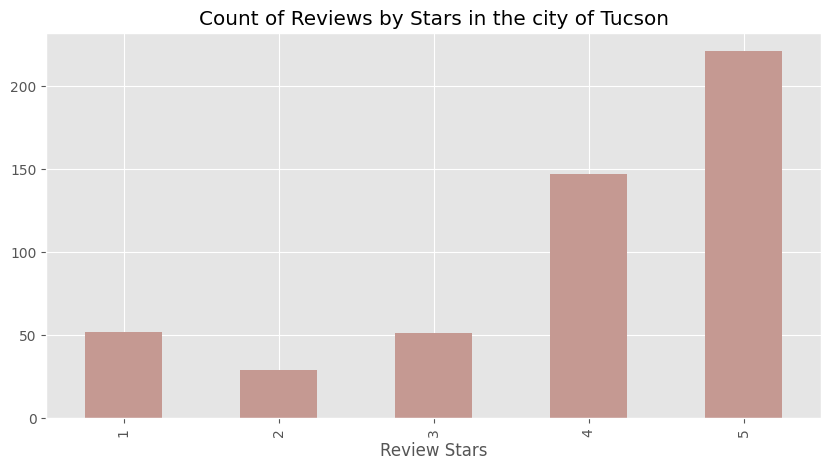

In [23]:
# show the number of time each rating/stars occurs
ax = tucson_sample['stars_y'].value_counts().sort_index().plot(kind='bar',
          title='Count of Reviews by Stars in the city of Tucson',
          figsize=(10, 5), color='#c59992')
ax.set_xlabel('Review Stars')
plt.show()

### Starting with NLTK

Basic analysis with one example

In [24]:
example = tucson_sample['text'].values[50]
print(example)

While I did not order the pizza, the customer service I received from Mindy was above and beyond. It was my first time visiting and I wasn't sure how this whole take and bake worked. She stopped what she was doing and patiently explained all of my questions. Including discount days and the discount for ordering online!! I look forward to placing my discounted order and trying this take and bake.


In [27]:
tokens = nltk.word_tokenize(example)
tokens[:10]

['While', 'I', 'did', 'not', 'order', 'the', 'pizza', ',', 'the', 'customer']

In [28]:
# part of speach values
tagged = nltk.pos_tag(tokens)
tagged[:10]

[('While', 'IN'),
 ('I', 'PRP'),
 ('did', 'VBD'),
 ('not', 'RB'),
 ('order', 'NN'),
 ('the', 'DT'),
 ('pizza', 'NN'),
 (',', ','),
 ('the', 'DT'),
 ('customer', 'NN')]

In [29]:
entities = nltk.chunk.ne_chunk(tagged)
entities.pprint()

(S
  While/IN
  I/PRP
  did/VBD
  not/RB
  order/NN
  the/DT
  pizza/NN
  ,/,
  the/DT
  customer/NN
  service/NN
  I/PRP
  received/VBD
  from/IN
  (PERSON Mindy/NNP)
  was/VBD
  above/IN
  and/CC
  beyond/IN
  ./.
  It/PRP
  was/VBD
  my/PRP$
  first/JJ
  time/NN
  visiting/NN
  and/CC
  I/PRP
  was/VBD
  n't/RB
  sure/JJ
  how/WRB
  this/DT
  whole/JJ
  take/NN
  and/CC
  bake/NN
  worked/VBN
  ./.
  She/PRP
  stopped/VBD
  what/WP
  she/PRP
  was/VBD
  doing/VBG
  and/CC
  patiently/RB
  explained/VBD
  all/DT
  of/IN
  my/PRP$
  questions/NNS
  ./.
  Including/VBG
  discount/NN
  days/NNS
  and/CC
  the/DT
  discount/NN
  for/IN
  ordering/VBG
  online/NN
  !/.
  !/.
  I/PRP
  look/VBP
  forward/RB
  to/TO
  placing/VBG
  my/PRP$
  discounted/VBN
  order/NN
  and/CC
  trying/VBG
  this/DT
  take/NN
  and/CC
  bake/NN
  ./.)


### Starting with Vader
Classify the sentences by Positive, Neutral, or Negative

In [30]:
from nltk.sentiment import SentimentIntensityAnalyzer
from tqdm.notebook import tqdm

sia = SentimentIntensityAnalyzer()

In [31]:
sia

In [32]:
# example with the neg/ney/pos
sia.polarity_scores('I am so happy!')

{'neg': 0.0, 'neu': 0.318, 'pos': 0.682, 'compound': 0.6468}

In [33]:
# example with a negative sentence
sia.polarity_scores('This is the worst thing ever.')

{'neg': 0.451, 'neu': 0.549, 'pos': 0.0, 'compound': -0.6249}

In [34]:
# run sia on the tucson example
sia.polarity_scores(example)

{'neg': 0.064, 'neu': 0.919, 'pos': 0.017, 'compound': -0.5017}

In [35]:
# run the polarity score on the entire tucson sample
res = {}
for i, row in tqdm(tucson_sample.iterrows(), total=len(tucson_sample)):
    text = row['text']
    myid = row['review_id']
    res[myid] = sia.polarity_scores(text)

  0%|          | 0/500 [00:00<?, ?it/s]

In [36]:
# show the result dictionary
res

{'Q8k6bndVPPDAQl9KuU9POA': {'neg': 0.174,
  'neu': 0.767,
  'pos': 0.059,
  'compound': -0.6044},
 'vKQdw2cgHsdxlwyZUDu-WA': {'neg': 0.0,
  'neu': 0.54,
  'pos': 0.46,
  'compound': 0.915},
 '4LuT9_uKT--jfsPPAYvXng': {'neg': 0.122,
  'neu': 0.745,
  'pos': 0.133,
  'compound': 0.1164},
 'VAJn5Wl41yAwgMXPcGSHlA': {'neg': 0.074,
  'neu': 0.855,
  'pos': 0.071,
  'compound': -0.5596},
 'jYUhqcQ4T_bC9g7dkZmS6Q': {'neg': 0.0,
  'neu': 0.619,
  'pos': 0.381,
  'compound': 0.9796},
 'SKY_UwT57c7x2_XwLLkB7g': {'neg': 0.0,
  'neu': 0.784,
  'pos': 0.216,
  'compound': 0.8587},
 '2Ux44iq9-wPb7dQcoZFA6A': {'neg': 0.0,
  'neu': 0.801,
  'pos': 0.199,
  'compound': 0.9283},
 'gK8r0RWY2_0yF-_5rh998A': {'neg': 0.027,
  'neu': 0.883,
  'pos': 0.091,
  'compound': 0.9586},
 'Xx42zaXUP3_71k7bGHwxpA': {'neg': 0.0,
  'neu': 0.781,
  'pos': 0.219,
  'compound': 0.6369},
 '4clZKuxpxBGjt81amNS5Ng': {'neg': 0.0,
  'neu': 0.598,
  'pos': 0.402,
  'compound': 0.877},
 '7WGnNxbET9YcVO5V8BoU8g': {'neg': 0.0,
  'n

In [37]:
# store the results dictionary in a dataframe
vaders = pd.DataFrame(res).T
vaders = vaders.reset_index().rename(columns={'index': 'review_id'})
vaders = vaders.merge(tucson_sample, how='left')

In [38]:
# show vader dataframe with the sentiment score
vaders.head(10)

,review_id,neg,neu,pos,compound,business_id,name,address,city,state,...,attributes,categories,hours,user_id,stars_y,useful,funny,cool,text,date
0,Q8k6bndVPPDAQl9KuU9POA,0.174,0.767,0.059,-0.6044,wghnIlMb_i5U46HMBGx9ig,China Dragon Restaurant,"1625 W Valencia Rd, Ste 101-103",Tucson,AZ,...,"{'WiFi': ''no'', 'BusinessParking': '{'garage'...","Restaurants, Chinese","{'Monday': '11:0-21:0', 'Tuesday': '11:0-21:0'...",1HUAEUkVOLZ5DptFf7oIvQ,2,1,0,0,Food used to great years ago but getting reall...,2016-02-23 18:05:34
1,vKQdw2cgHsdxlwyZUDu-WA,0.000,0.540,0.460,0.9150,wghnIlMb_i5U46HMBGx9ig,China Dragon Restaurant,"1625 W Valencia Rd, Ste 101-103",Tucson,AZ,...,"{'WiFi': ''no'', 'BusinessParking': '{'garage'...","Restaurants, Chinese","{'Monday': '11:0-21:0', 'Tuesday': '11:0-21:0'...",PiRmHf4zfgo-etVA2-dUJg,4,0,0,0,I really enjoyed my BBQ pork chow mein. The se...,2017-07-19 22:09:13
2,4LuT9_uKT--jfsPPAYvXng,0.122,0.745,0.133,0.1164,wghnIlMb_i5U46HMBGx9ig,China Dragon Restaurant,"1625 W Valencia Rd, Ste 101-103",Tucson,AZ,...,"{'WiFi': ''no'', 'BusinessParking': '{'garage'...","Restaurants, Chinese","{'Monday': '11:0-21:0', 'Tuesday': '11:0-21:0'...",8LRqff_u-lHYjeg9sIDcUQ,4,0,0,0,I called in an order for pickup and for $30 go...,2017-11-08 07:48:23
3,VAJn5Wl41yAwgMXPcGSHlA,0.074,0.855,0.071,-0.5596,wghnIlMb_i5U46HMBGx9ig,China Dragon Restaurant,"1625 W Valencia Rd, Ste 101-103",Tucson,AZ,...,"{'WiFi': ''no'', 'BusinessParking': '{'garage'...","Restaurants, Chinese","{'Monday': '11:0-21:0', 'Tuesday': '11:0-21:0'...",Kyw24zTGZ6RkSTZos8zh_A,1,0,0,0,Waitress was rude when explaining that somethi...,2017-03-16 22:07:20
4,jYUhqcQ4T_bC9g7dkZmS6Q,0.000,0.619,0.381,0.9796,wghnIlMb_i5U46HMBGx9ig,China Dragon Restaurant,"1625 W Valencia Rd, Ste 101-103",Tucson,AZ,...,"{'WiFi': ''no'', 'BusinessParking': '{'garage'...","Restaurants, Chinese","{'Monday': '11:0-21:0', 'Tuesday': '11:0-21:0'...",b_zVJ9n6qiUpGZGM2L4qVg,5,0,0,0,Love this place! I have been going here since ...,2011-05-02 21:04:11
5,SKY_UwT57c7x2_XwLLkB7g,0.000,0.784,0.216,0.8587,wghnIlMb_i5U46HMBGx9ig,China Dragon Restaurant,"1625 W Valencia Rd, Ste 101-103",Tucson,AZ,...,"{'WiFi': ''no'', 'BusinessParking': '{'garage'...","Restaurants, Chinese","{'Monday': '11:0-21:0', 'Tuesday': '11:0-21:0'...",E4QsPSgniD2oFm3xI5K3sg,1,1,0,1,Food was very good until I found a wasp in my ...,2017-04-10 02:58:07
6,2Ux44iq9-wPb7dQcoZFA6A,0.000,0.801,0.199,0.9283,wghnIlMb_i5U46HMBGx9ig,China Dragon Restaurant,"1625 W Valencia Rd, Ste 101-103",Tucson,AZ,...,"{'WiFi': ''no'', 'BusinessParking': '{'garage'...","Restaurants, Chinese","{'Monday': '11:0-21:0', 'Tuesday': '11:0-21:0'...",4aDP4qxTFiC6D3zIeFTjhg,4,0,0,0,It's been our favorite Chinese restaurant for ...,2017-08-11 04:40:12
7,gK8r0RWY2_0yF-_5rh998A,0.027,0.883,0.091,0.9586,wghnIlMb_i5U46HMBGx9ig,China Dragon Restaurant,"1625 W Valencia Rd, Ste 101-103",Tucson,AZ,...,"{'WiFi': ''no'', 'BusinessParking': '{'garage'...","Restaurants, Chinese","{'Monday': '11:0-21:0', 'Tuesday': '11:0-21:0'...",1HnXRi1qGx5cog4T2Yitfg,4,1,0,1,"El ""Dragon Chino"" o ""China Dragon"" es un peque...",2012-11-11 05:23:08
8,Xx42zaXUP3_71k7bGHwxpA,0.000,0.781,0.219,0.6369,wghnIlMb_i5U46HMBGx9ig,China Dragon Restaurant,"1625 W Valencia Rd, Ste 101-103",Tucson,AZ,...,"{'WiFi': ''no'', 'BusinessParking': '{'garage'...","Restaurants, Chinese","{'Monday': '11:0-21:0', 'Tuesday': '11:0-21:0'...",bUsnloyxec8_C0myvMB2vg,3,1,0,0,not many chinese restaurants in area\nlove the...,2018-04-17 04:07:10
9,4clZKuxpxBGjt81amNS5Ng,0.000,0.598,0.402,0.8770,wghnIlMb_i5U46HMBGx9ig,China Dragon Restaurant,"1625 W Valencia Rd, Ste 101-103",Tucson,AZ,...,"{'WiFi': ''no'', 'BusinessParking': '{'garage'...","Restaurants, Chinese","{'Monday': '11:0-21:0', 'Tuesday': '11:0-21:0'...",SRuKAMyjgc-NyCz6NHukXQ,5,0,0,0,Highly recommend this place for Chinese! Food ...,2016-06-26 02:58:22


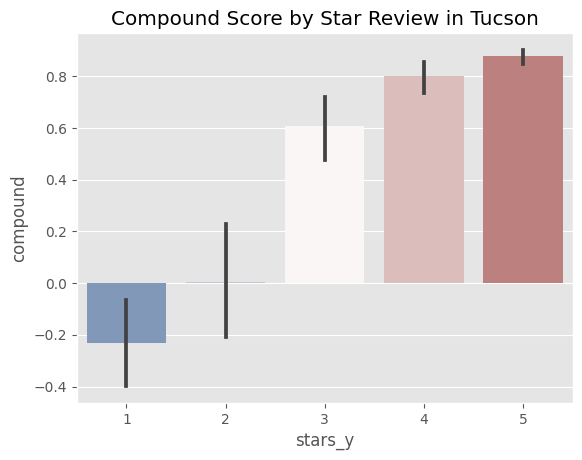

In [39]:
# let's plot the results
ax = sns.barplot(data=vaders, x='stars_y', y='compound', palette='vlag')
ax.set_title('Compound Score by Star Review in Tucson')
plt.show()

# lower star ratings have lower compound scores!

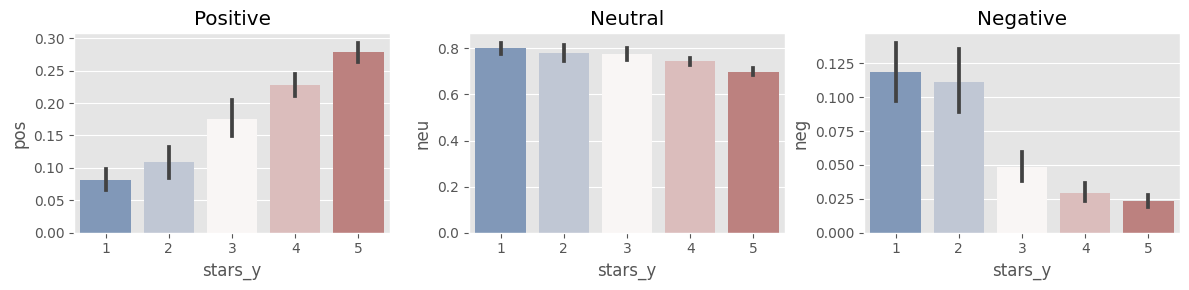

In [40]:
#let's plot each of the sentiments in separate plots
fig, axs = plt.subplots(1, 3, figsize=(12, 3))
sns.barplot(data=vaders, x='stars_y', y='pos', ax=axs[0], palette='vlag')
sns.barplot(data=vaders, x='stars_y', y='neu', ax=axs[1], palette='vlag')
sns.barplot(data=vaders, x='stars_y', y='neg', ax=axs[2], palette='vlag')
axs[0].set_title('Positive')
axs[1].set_title('Neutral')
axs[2].set_title('Negative')
plt.tight_layout()
plt.show()

# the higher the star rating, the nicer the reviews

### Trying the Roberta pre-trained model

In [41]:
# imports
!pip install transformers
from transformers import AutoTokenizer
from transformers import AutoModelForSequenceClassification
from scipy.special import softmax

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 48.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.9/294.9 kB 30.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 57.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 64.3 MB/s eta 0:00:00


In [42]:
MODEL = f"cardiffnlp/twitter-roberta-base-sentiment"
tokenizer = AutoTokenizer.from_pretrained(MODEL)
model = AutoModelForSequenceClassification.from_pretrained(MODEL)

In [43]:
# let's see the vader results to compare with the roberta results
# VADER results on example
print(example)
sia.polarity_scores(example)

While I did not order the pizza, the customer service I received from Mindy was above and beyond. It was my first time visiting and I wasn't sure how this whole take and bake worked. She stopped what she was doing and patiently explained all of my questions. Including discount days and the discount for ordering online!! I look forward to placing my discounted order and trying this take and bake.


{'neg': 0.064, 'neu': 0.919, 'pos': 0.017, 'compound': -0.5017}

In [44]:
# now let's see the same sentence example for roberta
# Run for Roberta Model
encoded_text = tokenizer(example, return_tensors='pt')
output = model(**encoded_text)
scores = output[0][0].detach().numpy()
scores = softmax(scores)
scores_dict = {
    'roberta_neg' : scores[0],
    'roberta_neu' : scores[1],
    'roberta_pos' : scores[2]
}
print(scores_dict)

{'roberta_neg': 0.017457029, 'roberta_neu': 0.07699964, 'roberta_pos': 0.90554327}


In [45]:
# now let's apply it to the entire tucson sample

def polarity_scores_roberta(example):
    encoded_text = tokenizer(example, return_tensors='pt')
    output = model(**encoded_text)
    scores = output[0][0].detach().numpy()
    scores = softmax(scores)
    scores_dict = {
        'roberta_neg' : scores[0],
        'roberta_neu' : scores[1],
        'roberta_pos' : scores[2]
    }
    return scores_dict

In [46]:
res = {}
for i, row in tqdm(tucson_sample.iterrows(), total=len(tucson_sample)):
    try:
        text = row['text']
        myid = row['review_id']
        vader_result = sia.polarity_scores(text)
        vader_result_rename = {}
        for key, value in vader_result.items():
            vader_result_rename[f"vader_{key}"] = value
        roberta_result = polarity_scores_roberta(text)
        both = {**vader_result_rename, **roberta_result}
        res[myid] = both
    except RuntimeError:
        print(f'Broke for id {myid}')

  0%|          | 0/500 [00:00<?, ?it/s]

Broke for id TAB6c0iyy3uOg9azQ793-g
Broke for id 4C9EstICIoP6Kz4sWpqRkQ
Broke for id 2VLvvwHZ6xJ_q6oUYyFhVg
Broke for id uWDAPbfIQm9axGBWH9yDKw


###Note
when it breaks, it means it had difficulties running through the Roberta model

In [47]:
results_tucson = pd.DataFrame(res).T
results_tucson = results_tucson.reset_index().rename(columns={'index': 'review_id'})
results_tucson = results_tucson.merge(tucson_sample, how='left')

In [48]:
# show the new dataframe
# it has the vader and roberta results!
results_tucson.head(10)

,review_id,vader_neg,vader_neu,vader_pos,vader_compound,roberta_neg,roberta_neu,roberta_pos,business_id,name,...,attributes,categories,hours,user_id,stars_y,useful,funny,cool,text,date
0,Q8k6bndVPPDAQl9KuU9POA,0.174,0.767,0.059,-0.6044,0.580677,0.354304,0.065019,wghnIlMb_i5U46HMBGx9ig,China Dragon Restaurant,...,"{'WiFi': ''no'', 'BusinessParking': '{'garage'...","Restaurants, Chinese","{'Monday': '11:0-21:0', 'Tuesday': '11:0-21:0'...",1HUAEUkVOLZ5DptFf7oIvQ,2,1,0,0,Food used to great years ago but getting reall...,2016-02-23 18:05:34
1,vKQdw2cgHsdxlwyZUDu-WA,0.000,0.540,0.460,0.9150,0.001290,0.006696,0.992014,wghnIlMb_i5U46HMBGx9ig,China Dragon Restaurant,...,"{'WiFi': ''no'', 'BusinessParking': '{'garage'...","Restaurants, Chinese","{'Monday': '11:0-21:0', 'Tuesday': '11:0-21:0'...",PiRmHf4zfgo-etVA2-dUJg,4,0,0,0,I really enjoyed my BBQ pork chow mein. The se...,2017-07-19 22:09:13
2,4LuT9_uKT--jfsPPAYvXng,0.122,0.745,0.133,0.1164,0.011237,0.099413,0.889350,wghnIlMb_i5U46HMBGx9ig,China Dragon Restaurant,...,"{'WiFi': ''no'', 'BusinessParking': '{'garage'...","Restaurants, Chinese","{'Monday': '11:0-21:0', 'Tuesday': '11:0-21:0'...",8LRqff_u-lHYjeg9sIDcUQ,4,0,0,0,I called in an order for pickup and for $30 go...,2017-11-08 07:48:23
3,VAJn5Wl41yAwgMXPcGSHlA,0.074,0.855,0.071,-0.5596,0.631884,0.295094,0.073022,wghnIlMb_i5U46HMBGx9ig,China Dragon Restaurant,...,"{'WiFi': ''no'', 'BusinessParking': '{'garage'...","Restaurants, Chinese","{'Monday': '11:0-21:0', 'Tuesday': '11:0-21:0'...",Kyw24zTGZ6RkSTZos8zh_A,1,0,0,0,Waitress was rude when explaining that somethi...,2017-03-16 22:07:20
4,jYUhqcQ4T_bC9g7dkZmS6Q,0.000,0.619,0.381,0.9796,0.001394,0.005163,0.993443,wghnIlMb_i5U46HMBGx9ig,China Dragon Restaurant,...,"{'WiFi': ''no'', 'BusinessParking': '{'garage'...","Restaurants, Chinese","{'Monday': '11:0-21:0', 'Tuesday': '11:0-21:0'...",b_zVJ9n6qiUpGZGM2L4qVg,5,0,0,0,Love this place! I have been going here since ...,2011-05-02 21:04:11
5,SKY_UwT57c7x2_XwLLkB7g,0.000,0.784,0.216,0.8587,0.484013,0.333899,0.182087,wghnIlMb_i5U46HMBGx9ig,China Dragon Restaurant,...,"{'WiFi': ''no'', 'BusinessParking': '{'garage'...","Restaurants, Chinese","{'Monday': '11:0-21:0', 'Tuesday': '11:0-21:0'...",E4QsPSgniD2oFm3xI5K3sg,1,1,0,1,Food was very good until I found a wasp in my ...,2017-04-10 02:58:07
6,2Ux44iq9-wPb7dQcoZFA6A,0.000,0.801,0.199,0.9283,0.001105,0.010662,0.988233,wghnIlMb_i5U46HMBGx9ig,China Dragon Restaurant,...,"{'WiFi': ''no'', 'BusinessParking': '{'garage'...","Restaurants, Chinese","{'Monday': '11:0-21:0', 'Tuesday': '11:0-21:0'...",4aDP4qxTFiC6D3zIeFTjhg,4,0,0,0,It's been our favorite Chinese restaurant for ...,2017-08-11 04:40:12
7,gK8r0RWY2_0yF-_5rh998A,0.027,0.883,0.091,0.9586,0.007958,0.139656,0.852386,wghnIlMb_i5U46HMBGx9ig,China Dragon Restaurant,...,"{'WiFi': ''no'', 'BusinessParking': '{'garage'...","Restaurants, Chinese","{'Monday': '11:0-21:0', 'Tuesday': '11:0-21:0'...",1HnXRi1qGx5cog4T2Yitfg,4,1,0,1,"El ""Dragon Chino"" o ""China Dragon"" es un peque...",2012-11-11 05:23:08
8,Xx42zaXUP3_71k7bGHwxpA,0.000,0.781,0.219,0.6369,0.070823,0.364559,0.564617,wghnIlMb_i5U46HMBGx9ig,China Dragon Restaurant,...,"{'WiFi': ''no'', 'BusinessParking': '{'garage'...","Restaurants, Chinese","{'Monday': '11:0-21:0', 'Tuesday': '11:0-21:0'...",bUsnloyxec8_C0myvMB2vg,3,1,0,0,not many chinese restaurants in area\nlove the...,2018-04-17 04:07:10
9,4clZKuxpxBGjt81amNS5Ng,0.000,0.598,0.402,0.8770,0.001301,0.008536,0.990163,wghnIlMb_i5U46HMBGx9ig,China Dragon Restaurant,...,"{'WiFi': ''no'', 'BusinessParking': '{'garage'...","Restaurants, Chinese","{'Monday': '11:0-21:0', 'Tuesday': '11:0-21:0'...",SRuKAMyjgc-NyCz6NHukXQ,5,0,0,0,Highly recommend this place for Chinese! Food ...,2016-06-26 02:58:22


### Compare Vader and Roberta

In [49]:
# show the columns
results_tucson.columns

Index(['review_id', 'vader_neg', 'vader_neu', 'vader_pos', 'vader_compound',
       'roberta_neg', 'roberta_neu', 'roberta_pos', 'business_id', 'name',
       'address', 'city', 'state', 'postal_code', 'latitude', 'longitude',
       'stars_x', 'review_count', 'is_open', 'attributes', 'categories',
       'hours', 'user_id', 'stars_y', 'useful', 'funny', 'cool', 'text',
       'date'],
      dtype='object')

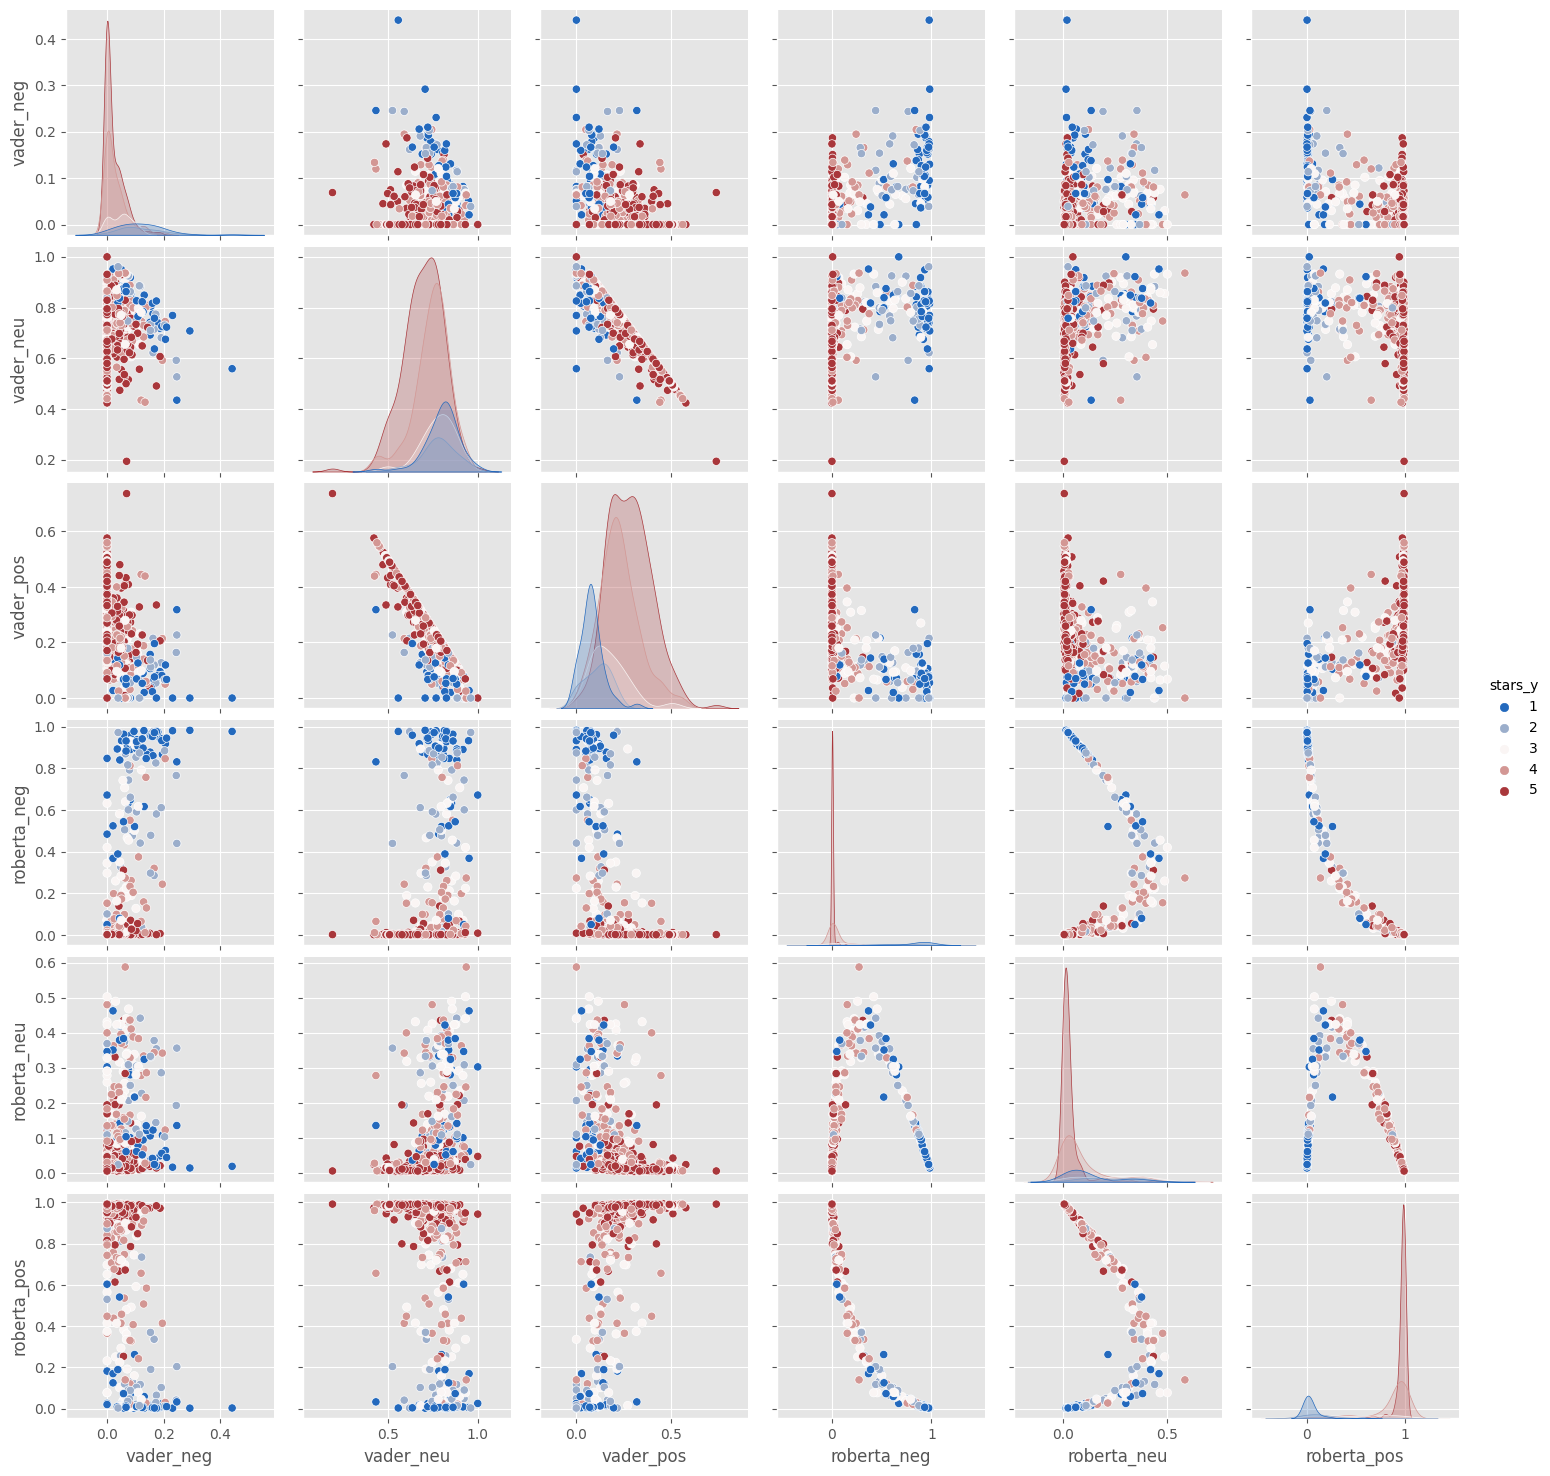

In [50]:
# plot the comparison
sns.pairplot(data=results_tucson,
             vars=['vader_neg', 'vader_neu', 'vader_pos',
                  'roberta_neg', 'roberta_neu', 'roberta_pos'],
            hue='stars_y',
            palette='vlag')
plt.show()